In [29]:
from collections import Counter
from typing import List, Literal

import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

## Dataset

Load dataset from HuggingFace

In [30]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [31]:
# print three first examples
for i in range(3):
    print(f"Example {i+1}:")
    print(ds['train'][i]['abstract'])
    print(ds['train'][i]['categories'])
    print("---" * 20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [32]:
all_categories = ds['train']['categories'][:1000]
print(set(all_categories))

{'cs.CE cond-mat.stat-mech cs.MS cs.NA physics.data-an', 'quant-ph hep-th', 'cond-mat.soft cond-mat.stat-mech', 'math-ph math.MP math.OA', 'nucl-th hep-ph', 'math.GT math.DG', 'math.AG', 'math-ph math.MP math.RT', 'math.DS math-ph math.AP math.MP', 'quant-ph hep-th nlin.CD physics.atom-ph physics.chem-ph', 'q-bio.NC cond-mat.dis-nn physics.soc-ph', 'cs.IT cs.LG math.IT', 'cond-mat.stat-mech q-bio.NC', 'cond-mat.dis-nn cond-mat.str-el quant-ph', 'physics.atom-ph cond-mat.other', 'cs.DM cs.LO', 'cond-mat.other', 'cs.PF', 'cond-mat.stat-mech cond-mat.dis-nn', 'hep-th cond-mat.stat-mech', 'math.AP', 'math.CA math.AT', 'math.GM', 'cs.IT cs.AR math.IT', 'hep-ex hep-ph', 'q-fin.ST physics.data-an physics.soc-ph', 'cs.IT cs.CC math.IT', 'math.FA math.GN', 'math.OA math.KT', 'gr-qc astro-ph.HE', 'hep-th astro-ph hep-ph', 'math.QA math.RT', 'astro-ph gr-qc hep-ph', 'hep-ph astro-ph hep-th', 'math.DG gr-qc hep-th math-ph math.AP math.MP', 'hep-th gr-qc', 'cond-mat.stat-mech cond-mat.mtrl-sci cond

In [33]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


Select first 1000 samples that has single label:

In [34]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

In [35]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [36]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [37]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [38]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


## Text Encoder

### Bag of Words


Bag of Words (BoW) is a simple and commonly used text representation technique. It converts text into a fixed-length vector by counting the occurrences of each word in the text. This method ignores grammar and word order but retains the frequency of words.

In [39]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)

for i, vec in enumerate(vectors):
    print(f"Document {i+1}: {vec.toarray()}")

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


### TF-IDF

Tf-idf (Term Frequency-Inverse Document Frequency) is another popular text representation technique. It not only considers the frequency of words in a document but also how common or rare a word is across all documents. This helps to reduce the weight of common words and highlight more informative ones.

In [40]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vectors):
    print(f"TF-IDF for Document {i+1}:")
    print(vec.toarray())


TF-IDF for Document 1:
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF-IDF for Document 2:
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF-IDF for Document 3:
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.

### Word Embeddings

Word embeddings are dense vector representations of words that capture semantic relationships between them. They are typically pre-trained on large corpora and can be used to represent words in a continuous vector space, allowing for better generalization and understanding of word meanings.

In [41]:
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'intfloat/multilingual-e5-base',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(self, texts: List[str], mode: Literal['query', 'passage'] = 'query'):
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(self, texts, mode: Literal['query', 'passage'] = 'query') -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

In [42]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = EmbeddingVectorizer()
embeddings = vectorizer.transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i+1}:")
    print(emb[:10])  # Print first 10 dimensions for brevity
    print("#" * 20)

Embedding for Document 1:
[-0.014805685728788376, 0.031276602298021317, -0.01615864969789982, 0.00754533801227808, 0.04465828835964203, -0.0512365847826004, -0.014605079777538776, -0.048289183527231216, 0.05034765973687172, 0.0047387899830937386]
####################
Embedding for Document 2:
[0.01191739086061716, 0.03327367454767227, -0.025738948956131935, 0.026533041149377823, 0.031609632074832916, -0.021373169496655464, -0.012149802409112453, -0.03784849867224693, 0.04151829332113266, 1.3260889318189584e-05]
####################
Embedding for Document 3:
[0.012662852182984352, 0.039361219853162766, -0.024181142449378967, 0.01619778387248516, 0.007417779881507158, -0.030312353745102882, -0.014685547910630703, -0.038502875715494156, 0.006972378119826317, 0.017755985260009766]
####################
Embedding for Document 4:
[0.0063935876823961735, 0.04922204092144966, -0.02840282768011093, -0.013305852189660072, 0.005811082664877176, -0.04371508210897446, -0.008321711793541908, -0.04131

In [43]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

# convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())
X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

Shape of X_train_bow: (800, 10373)
Shape of X_test_bow: (200, 10373)

Shape of X_train_tfidf: (800, 10373)
Shape of X_test_tfidf: (200, 10373)

Shape of X_train_embeddings: (800, 768)
Shape of X_test_embeddings: (200, 768)



## Train and Test Machine Learning Models

In [44]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
    """
    Plots a confusion matrix with raw counts and normalized values using Seaborn.

    Parameters:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        label_list (list or dict): Class names (list or dict from ID to name).
        figure_name (str): Title of the plot.
        save_path (str, optional): Path to save the figure. If None, the figure will not be saved.
    """
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Map class indices to names
    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]

    # Create annotations with raw + normalized values
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotations[i, j] = f"{raw}\n({norm:.2%})"

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

### KMean

In [45]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters
    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        # Get all labels in this cluster
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    # Predict labels for test set
    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred,
        target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True
    )

    return y_pred, accuracy, report

In [46]:
# Train and test K-Means on different vectorized datasets
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id))
km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id))
km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(
    X_train_embeddings, y_train, X_test_embeddings, y_test, n_clusters=len(label_to_id))
# Print K-Means results
print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.5600
TF-IDF: 0.6150
Embeddings: 0.8400


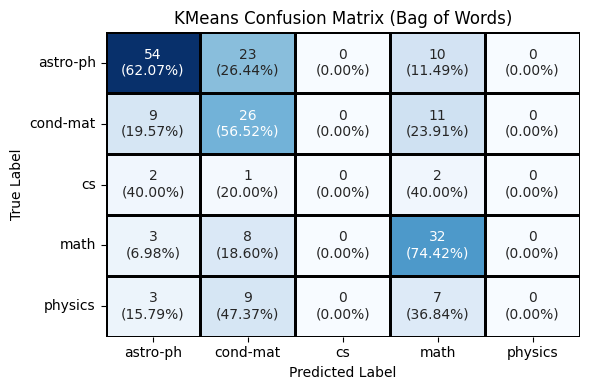

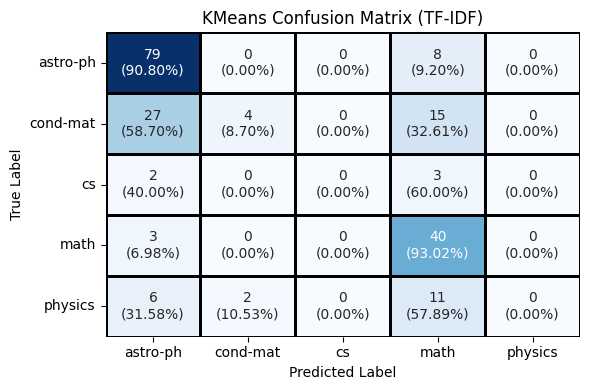

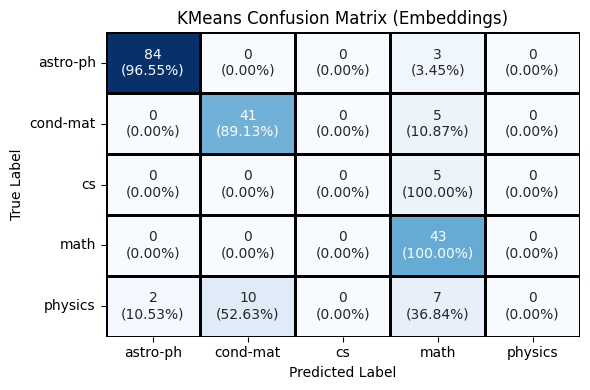

In [47]:
import os
os.makedirs("pdf/Figures", exist_ok=True)

# Draw confusion matrices
plot_confusion_matrix(y_test, km_bow_labels, sorted_labels, "KMeans Confusion Matrix (Bag of Words)", save_path="pdf/Figures/kmeans_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_labels, "KMeans Confusion Matrix (TF-IDF)", save_path="pdf/Figures/kmeans_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_labels, "KMeans Confusion Matrix (Embeddings)", save_path="pdf/Figures/kmeans_embeddings_confusion_matrix.pdf")

### KNN Classifier

KNN (K-Nearest Neighbors) is a simple and effective classification algorithm that classifies a data point based on the majority class of its k nearest neighbors in the feature space. It is often used for text classification tasks.

In [48]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [49]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(X_train_bow, y_train, X_test_bow, y_test)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print KNN results
print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.5300
TF-IDF: 0.8150
Embeddings: 0.8900


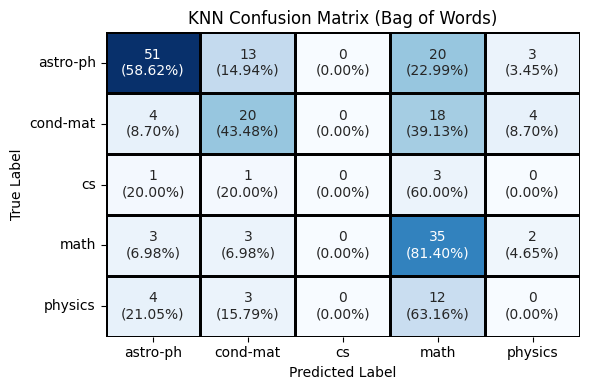

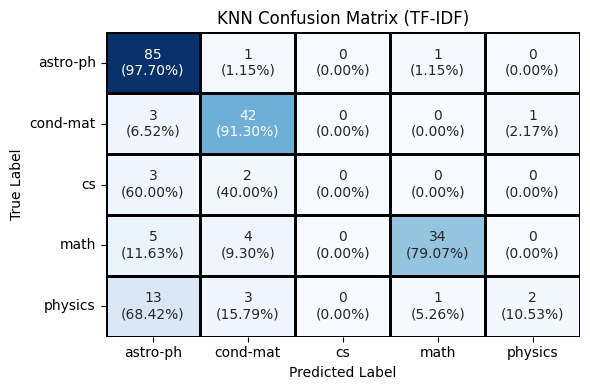

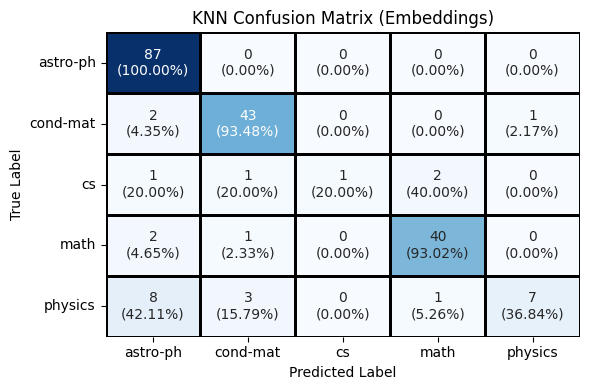

In [50]:
# Draw confusion matrices

plot_confusion_matrix(y_test, knn_bow_labels, sorted_labels, "KNN Confusion Matrix (Bag of Words)", "pdf/Figures/knn_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_tfidf_labels, sorted_labels, "KNN Confusion Matrix (TF-IDF)", "pdf/Figures/knn_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "KNN Confusion Matrix (Embeddings)", "pdf/Figures/knn_embeddings_confusion_matrix.pdf")

### Decision Tree

In [51]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred = dt.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [52]:
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(X_train_bow, y_train, X_test_bow, y_test)
dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test)
dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Decision Tree results
print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6350
TF-IDF: 0.5950
Embeddings: 0.7150


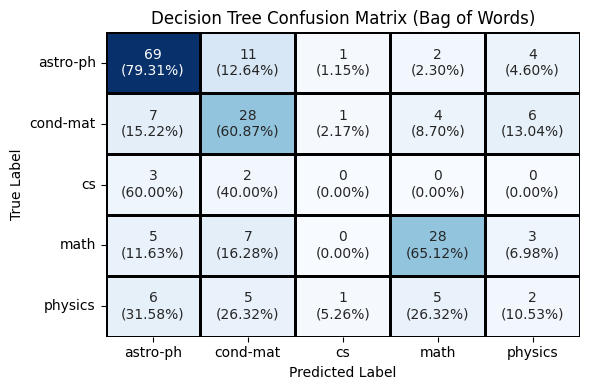

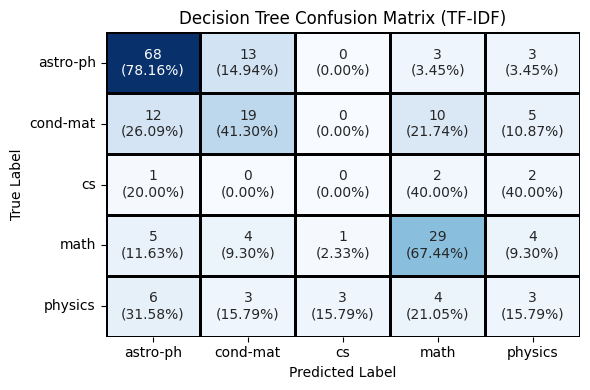

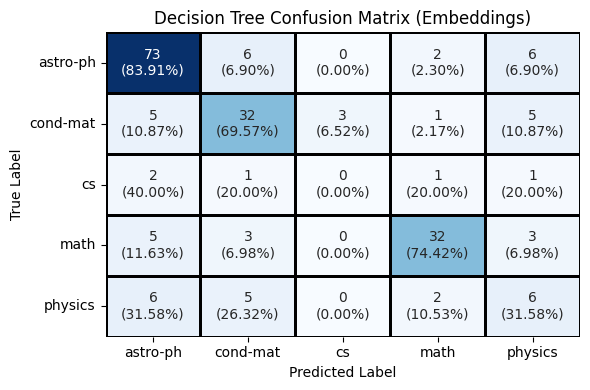

In [53]:
# Draw confusion matrices
plot_confusion_matrix(y_test, dt_bow_labels, sorted_labels, "Decision Tree Confusion Matrix (Bag of Words)", "pdf/Figures/dt_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_tfidf_labels, sorted_labels, "Decision Tree Confusion Matrix (TF-IDF)", "pdf/Figures/dt_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_embeddings_labels, sorted_labels, "Decision Tree Confusion Matrix (Embeddings)", "pdf/Figures/dt_embeddings_confusion_matrix.pdf")

### Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB

def train_and_test_naive_bayes(X_train, y_train, X_test, y_test):
    nb = GaussianNB()

    # Naive Bayes requires input to be in dense format
    X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    nb.fit(X_train_dense, y_train)

    # Predict on the test set
    y_pred = nb.predict(X_test_dense)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [55]:
# Train and test Naive Bayes on different vectorized datasets
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naive_bayes(X_train_bow, y_train, X_test_bow, y_test)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naive_bayes(X_train_tfidf, y_train, X_test_tfidf, y_test)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naive_bayes(X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Naive Bayes results
print("Accuracies for Naive Bayes:")
print(f"Bag of Words: {nb_bow_accuracy:.4f}")
print(f"TF-IDF: {nb_tfidf_accuracy:.4f}")
print(f"Embeddings: {nb_embeddings_accuracy:.4f}")

Accuracies for Naive Bayes:
Bag of Words: 0.8500
TF-IDF: 0.8300
Embeddings: 0.8900


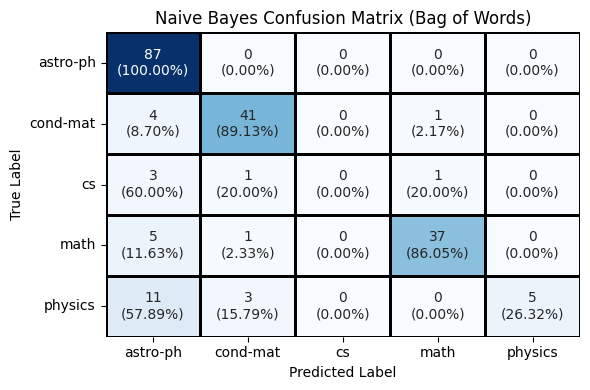

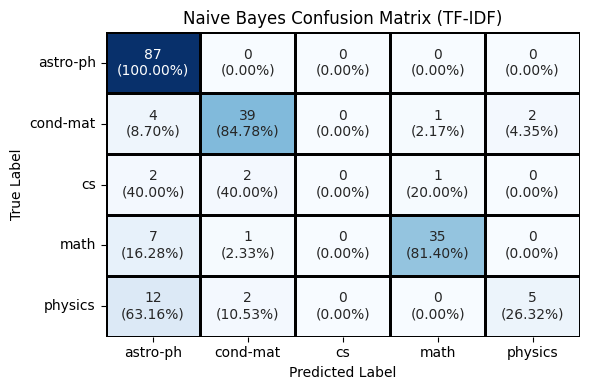

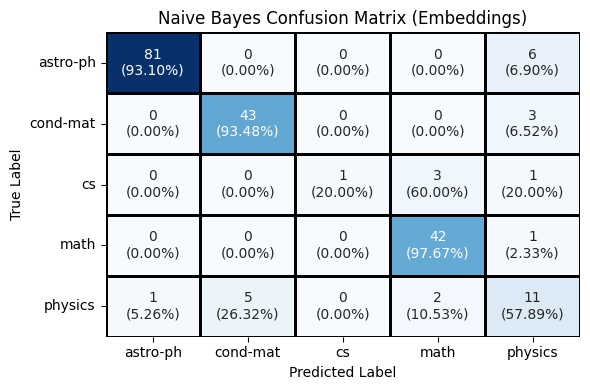

In [56]:
# Draw confusion matrices
plot_confusion_matrix(y_test, nb_bow_labels, sorted_labels, "Naive Bayes Confusion Matrix (Bag of Words)", "pdf/Figures/nb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_tfidf_labels, sorted_labels, "Naive Bayes Confusion Matrix (TF-IDF)", "pdf/Figures/nb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_embeddings_labels, sorted_labels, "Naive Bayes Confusion Matrix (Embeddings)", "pdf/Figures/nb_embeddings_confusion_matrix.pdf")